Keys in data_2d: dict_keys(['LL', 'LH', 'HL', 'HH'])


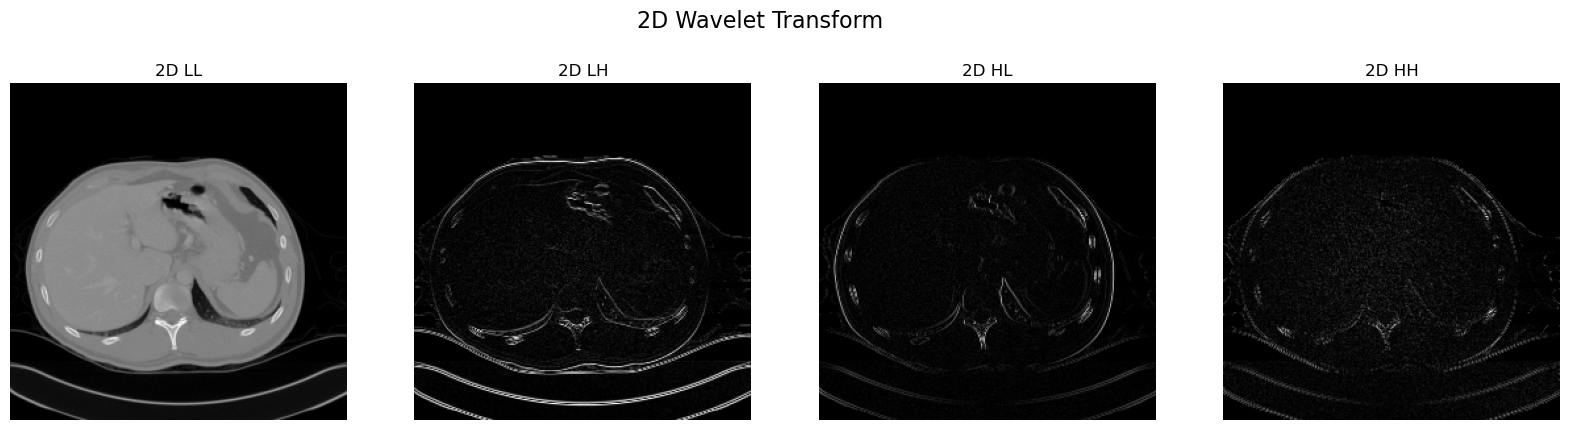

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def read_binary_file2d(filename):
    # Read the binary file
    with open(filename, 'rb') as file:
        depth = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
        rows = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
        cols = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
        
        data = np.fromfile(file, dtype=np.float32)
        data = data.reshape((depth, rows, cols))

    # Extract subbands
    LL = data[:, :rows//2, :cols//2]
    LH = data[:, :rows//2, cols//2:]
    HL = data[:, rows//2:, :cols//2]
    HH = data[:, rows//2:, cols//2:]

    # Create a dictionary to store the subbands
    subbands = {
        'LL': LL,
        'LH': LH,
        'HL': HL,
        'HH': HH
    }

    return subbands

def normalize(data):
    data = np.abs(data)
    data = data / np.max(data)
    return data

def display_images(data, title, transform_type):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(title, fontsize=16)
    
    keys = ['LL', 'LH', 'HL', 'HH']  # Explicit order
    for i, key in enumerate(keys):
        if key not in data:
            print(f"Key '{key}' not found in data")
            continue
        # Get the first slice along the depth dimension
        value = data[key][0]  # Display the first "depth" slice
        value = normalize(value)  # Normalize the data
        axes[i].imshow(value, cmap='gray')
        axes[i].set_title(f'{transform_type} {key}')
        axes[i].axis('off')
    
    plt.show()

# Read the binary file for 2D wavelet transform
filename = '../Serial/outputs/3out.bin'
data_2d = read_binary_file2d(filename)

# Debug statement to print the keys of the data structure
print("Keys in data_2d:", data_2d.keys())

# Display the images for 2D wavelet transform
display_images(data_2d, '2D Wavelet Transform', '2D')

Read dimensions from shape file: depth=78, rows=512, cols=512
Read data size: 20447232
[0.7071067811865476, 0.7071067811865476]
[-0.7071067811865476, 0.7071067811865476]


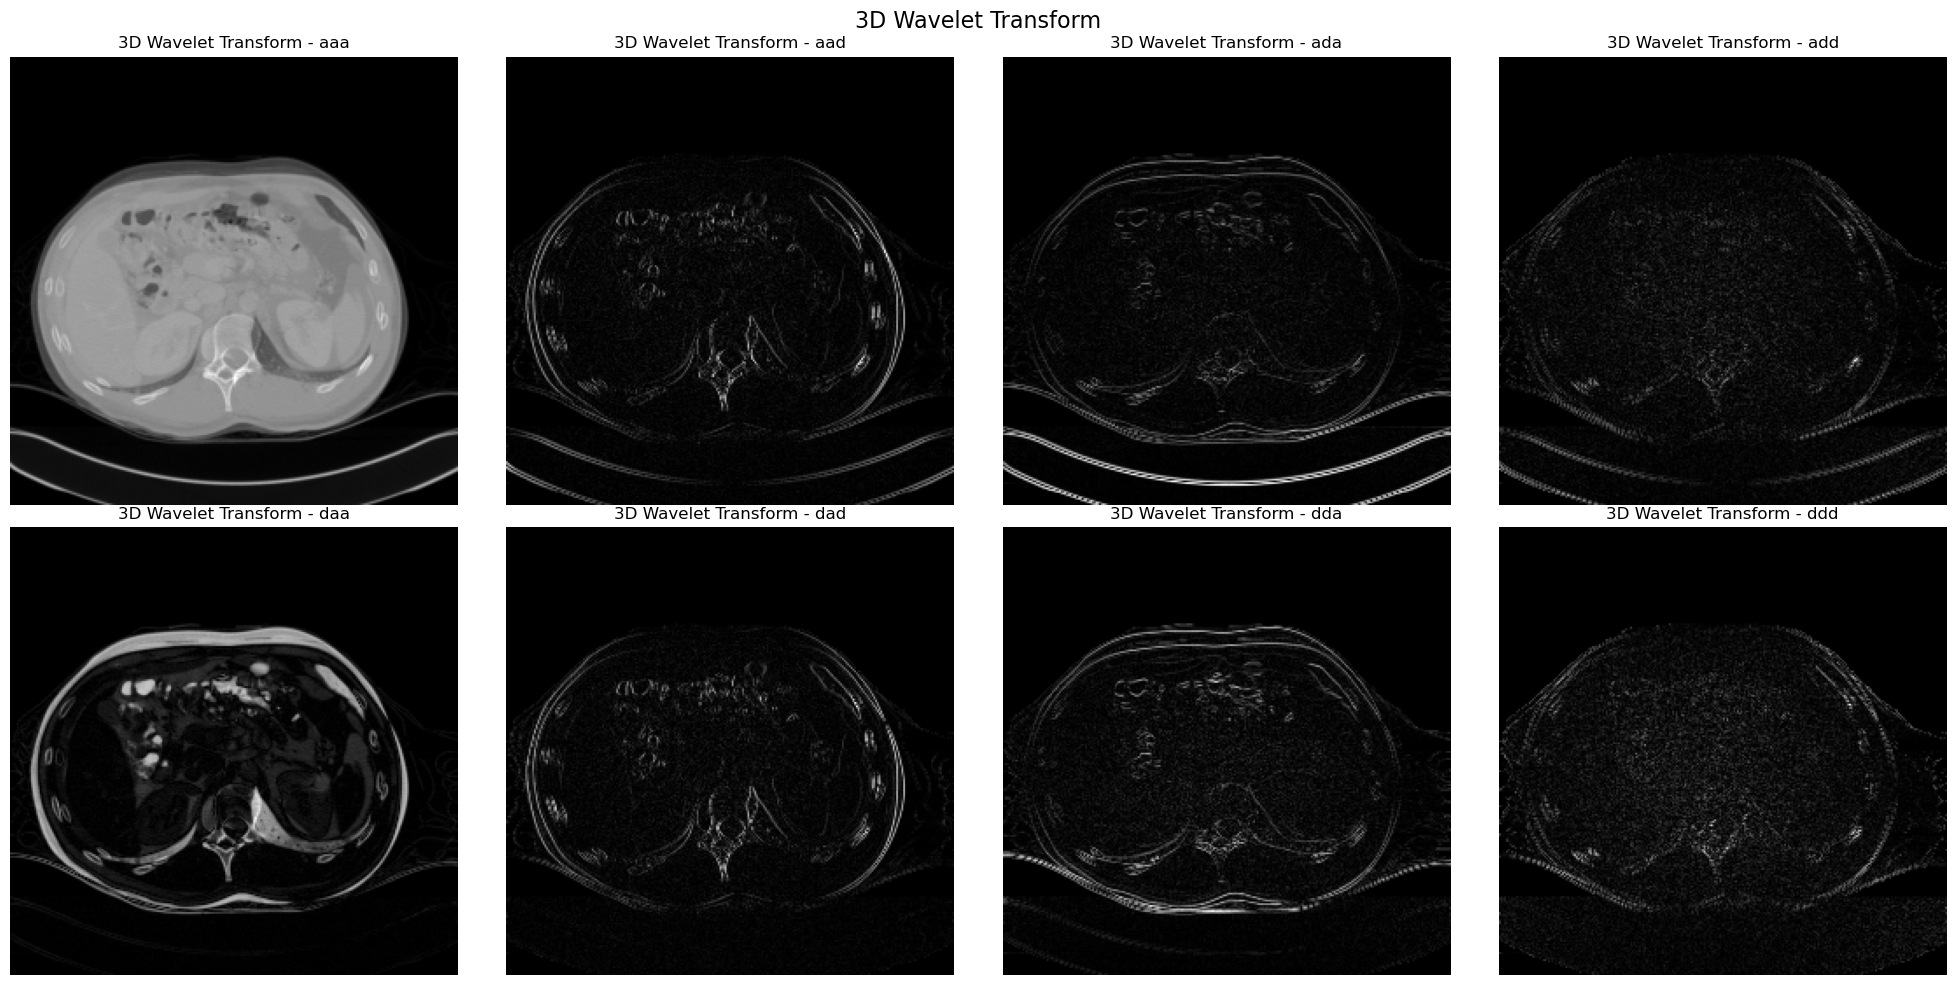

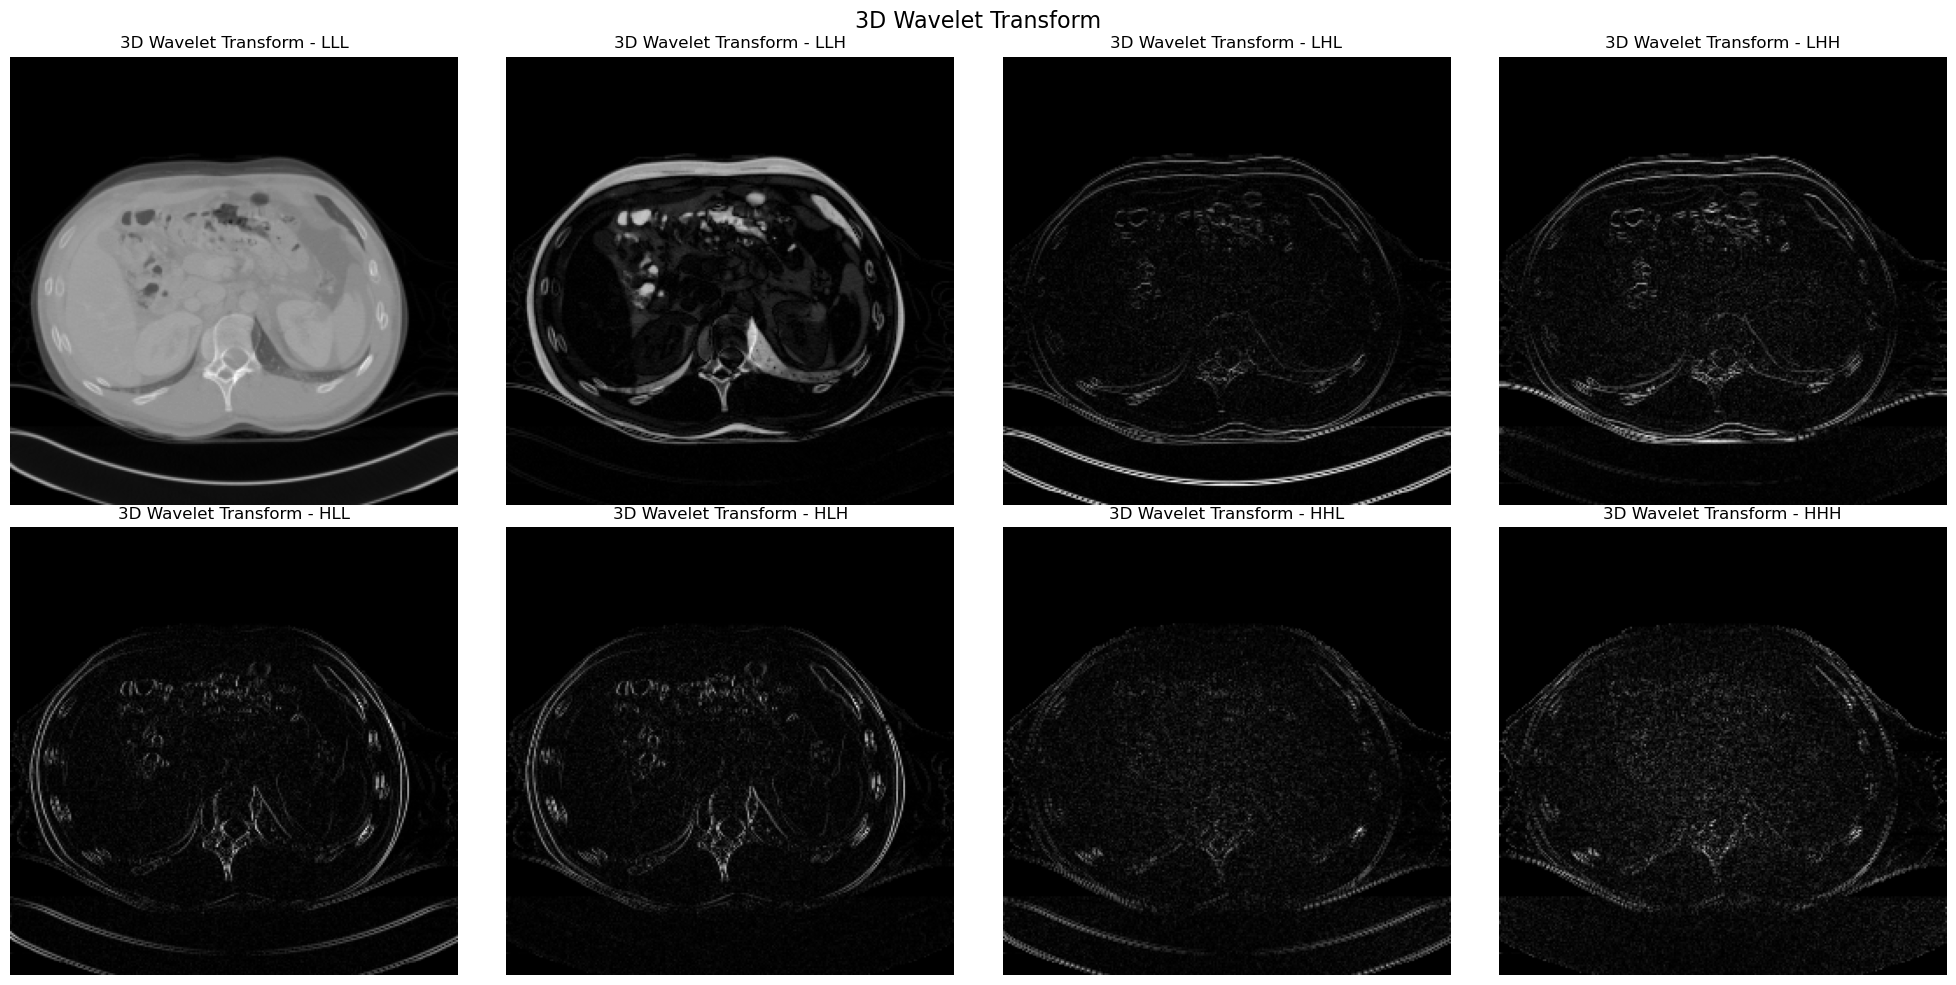

MSE for LLL: 9.067465001066921e-09
MSE for LLH: 164890.09375
MSE for LHL: 3.3129969878586962e-09
MSE for LHH: 2637.166259765625
MSE for HLL: 164890.09375
MSE for HLH: 1.499702445562079e-10
MSE for HHL: 2637.166259765625
MSE for HHH: 5.1091398473035454e-11

Original energy: 9282319810560.0
Subbands energy: 9282315168704.0
Energy is conserved.


In [13]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

def read_shape_file(shape_filename):
    with open(shape_filename, 'r') as f:
        shape = tuple(map(int, f.read().strip().split(',')))
    return shape

def read_binary_file(filename, shape_filename):
    # Read the shape information
    depth, rows, cols = read_shape_file(shape_filename)
    print(f"Read dimensions from shape file: depth={depth}, rows={rows}, cols={cols}")
    
    # Read the binary file
    with open(filename, 'rb') as file:
        data = np.fromfile(file, dtype=np.float32)
        print(f"Read data size: {data.size}")
        
        data = data.reshape((depth, rows, cols))
    return data

def read_wavelet3d_result(filename):
    subbands = {}
    with open(filename, 'rb') as file:
        for key in ['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH']:
            depth = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            rows = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            cols = int(np.fromfile(file, dtype=np.uint64, count=1)[0])
            data = np.fromfile(file, dtype=np.float32, count=depth*rows*cols)
            data = data.reshape((depth, rows, cols))
            subbands[key] = data
    return subbands

def normalize(data):
    data = np.abs(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    return data

def display_images(data, title, keys):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)

    for i, key in enumerate(keys):
        if key not in data:
            print(f"Key '{key}' not found in data")
            continue
        # Get the first slice along the depth dimension
        value = data[key][0]  # Display the first "depth" slice
        value = normalize(value)
        ax = axes[i // 4, i % 4]
        ax.imshow(value, cmap='gray')
        ax.set_title(f'{title} - {key}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def check_energy_conservation(original_data, subbands):
    original_energy = np.sum(original_data ** 2)
    subbands_energy = sum(np.sum(subband ** 2) for subband in subbands.values())
    print("")
    print(f"Original energy: {original_energy}")
    print(f"Subbands energy: {subbands_energy}")
    if np.isclose(original_energy, subbands_energy, rtol=1e-5):
        print("Energy is conserved.")
    else:
        print("Warning: Energy is not conserved.")

def perform_3d_wavelet_transform_pywt(data, wavelet='haar'):
    coeffs = pywt.dwtn(data, wavelet=wavelet)
    return coeffs

# Read the original input data
original_filename = '../Binary/3/3.bin'
shape_filename = '../Binary/3/3_shape.txt'
original_data = read_binary_file(original_filename, shape_filename)

# Perform 3D wavelet transform using PyWavelets
coeffs_pywt = perform_3d_wavelet_transform_pywt(original_data, wavelet='haar')

# Haar filter coefficients in PyWavelets
wavelet = pywt.Wavelet('haar')
print(wavelet.dec_lo)  # Low-pass filter coefficients
print(wavelet.dec_hi)  # High-pass filter coefficients

# Read the results from the C++ implementation
cpp_filename = '../Serial/outputs/3out.bin'
data_cpp = read_wavelet3d_result(cpp_filename)

# Display the images for 3D wavelet transform using PyWavelets
display_images(coeffs_pywt, '3D Wavelet Transform', keys=['aaa', 'aad', 'ada', 'add', 'daa', 'dad', 'dda', 'ddd'])

# Display the images for 3D wavelet transform from C++ implementation
display_images(data_cpp, '3D Wavelet Transform', keys=['LLL', 'LLH', 'LHL', 'LHH', 'HLL', 'HLH', 'HHL', 'HHH'])

# Mapping between C++ keys and PyWavelets keys
cpp_to_pywt_keys = {
    'LLL': 'aaa', 'LLH': 'aad', 'LHL': 'ada', 'LHH': 'add',
    'HLL': 'daa', 'HLH': 'dad', 'HHL': 'dda', 'HHH': 'ddd'
}

# Compare the results with corrected key mapping
for cpp_key, pywt_key in cpp_to_pywt_keys.items():
    try:
        mse = np.mean((data_cpp[cpp_key] - coeffs_pywt[pywt_key]) ** 2)
        print(f"MSE for {cpp_key}: {mse}")
    except KeyError as e:
        print(f"KeyError: {e} for key {cpp_key}")

# Check energy conservation
check_energy_conservation(original_data, data_cpp)